In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/03_Strains_Control_30weeks_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

#  Import differential peaks from last time

In [3]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (55569, 24)
getDiffExpression selected transcripts (54547, 33)
annotatePeaks selected peaks (54547, 24)


In [4]:
comp_dict = pull_comparisons_get_diff(diff_peak)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Process for motif calling with Homer

Ty pointed out that running annotatePeaks.pl on a peak file adjusts the peak size to what is being annotated :O so we have to pull the original coordinates out of the ATAC file. The ATAC peak file from O'young's pipeline has an average peak size of about 270 so they are a little bigger than the NFR we like for ATAC seq. I'm unsure whether the best thing to do here would be to make them all 200 bp based on the center of the peak or if we should just use the merged peak sizes.

In the ATAC-seq pipeline we only consider the peaks within 200 bp of the peak center when calling differential peaks, and annotate peaks resizes the peak around the center during processing, so we can just read in the annotated peak file rather than resizing the peaks manually!

However, the code to resize peaks is still available in the H3K27Ac pipeline should you need it!

### Select distal differential peaks for motif analysis

In [5]:
diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS'])>3000, :]

# print to check that this worked
print(diff_peak.shape[0], 'peaks in differential peak file')
print()
print(diff_peak_distal.shape[0], 'distal peaks in differential peak file')


63491 peaks in differential peak file

38540 distal peaks in differential peak file


# Process in  Maggie

Here we just want to take peaks that are increased specifically in one strain when compared to another, but i would prefer to do this all in one go so that we can pool our power. Perhaps we can start by doing everything relevant to C57 - this would introduce duplicate peaks which could affect our overall power.

As compared to homer motif analysis here we will consider all pairwise differential peaks, since the mutations between the two strains could drive variation in either direction

To do this part it helps to have some understanding of the diffpeak file that homer puts out... the columns at the end are "group1 vs group2" with p value and log2fold change. The log2fold change here looks like this:  \

$\log2(\frac{group2 tags}{group1 tags})$  

So in this case things that are higher in group 1 will be negative and things that are higher in group 2 will be positive. Since C57 is group 1 in this case it all negative peaks will be up in C57

In [6]:
if not os.path.isdir('./differential_peaks/'):
    os.mkdir('./differential_peaks/')

In [9]:
# set cutoffs
fc = 1
pval = 0.05

for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):
    print(text, 'analysis')
    for comp in comp_dict.keys():
        # extract strains
        s1 = comp.split(' vs. ')[0].split('_')[1]
        s2 = comp.split(' vs. ')[1].split('_')[1]

        # write group 2 activated
        g1 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] < -fc)].index.tolist()
        print(len(g1), 'peaks upregualted in', s1, 'relative to', s2)
        df.iloc[:, :5].loc[g1, :].to_csv('./differential_peaks/'+s1+'_spec_'+s2+'_200bp'+text+'.txt', sep='\t')

        g2 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] > fc)].index.tolist()
        print(len(g2), 'peaks upregualted in', s2, 'relative to', s1)
        df.iloc[:, :5].loc[g2, :].to_csv('./differential_peaks/'+s2+'_spec_'+s1+'_200bp'+text+'.txt', sep='\t')

 analysis
294 peaks upregualted in c57 relative to balbc
589 peaks upregualted in balbc relative to c57
207 peaks upregualted in c57 relative to aj
467 peaks upregualted in aj relative to c57
132 peaks upregualted in balbc relative to aj
153 peaks upregualted in aj relative to balbc
_distal analysis
234 peaks upregualted in c57 relative to balbc
514 peaks upregualted in balbc relative to c57
167 peaks upregualted in c57 relative to aj
412 peaks upregualted in aj relative to c57
111 peaks upregualted in balbc relative to aj
127 peaks upregualted in aj relative to balbc


Extract sequences for maggie

In [10]:
if not os.path.isdir('./differential_fasta/'):
    os.mkdir('./differential_fasta/')

In [12]:
### c57 vs balb
MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp.txt -output ./differential_fasta/balbc_spec_c57_ref_200bp.fa
MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp.txt -output ./differential_fasta/balbc_spec_c57_mut_200bp.fa

MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp.txt -output ./differential_fasta/c57_spec_balbc_ref_200bp.fa
MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp.txt -output ./differential_fasta/c57_spec_balbc_mut_200bp.fa

# distal

MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -output ./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa
MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -output ./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa

MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -output ./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa
MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -output ./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa

### balb vs aj

MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -output ./differential_fasta/balbc_spec_aj_ref_200bp.fa
MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -output ./differential_fasta/balbc_spec_aj_mut_200bp.fa

MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -output ./differential_fasta/aj_spec_balbc_ref_200bp.fa
MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -output ./differential_fasta/aj_spec_balbc_mut_200bp.fa

# distal

MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -output ./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa
MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -output ./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa

MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -output ./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa
MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -output ./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa

### c57 vs aj

MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp.txt -output ./differential_fasta/c57_spec_aj_ref_200bp.fa
MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp.txt -output ./differential_fasta/c57_spec_aj_mut_200bp.fa

MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp.txt -output ./differential_fasta/aj_spec_c57_ref_200bp.fa
MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp.txt -output ./differential_fasta/aj_spec_c57_mut_200bp.fa

# distal

MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -output ./differential_fasta/c57_spec_aj_ref_200bp_distal.fa
MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -output ./differential_fasta/c57_spec_aj_mut_200bp_distal.fa

MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -output ./differential_fasta/aj_spec_c57_ref_200bp_distal.fa
MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -output ./differential_fasta/aj_spec_c57_mut_200bp_distal.fa


SyntaxError: invalid syntax (<ipython-input-12-947a031566b6>, line 2)

# Try running maggie with aggregated peaks

In [24]:
if not os.path.isdir('./maggie_output/'):
    os.mkdir('./maggie_output/')

balbc vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa \
-o ./maggie_output/balbc_c57_200bp/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/balbc_c57_200bp_distal/ \
-p 8

aj vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/aj_c57_200bp/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/aj_c57_200bp_distal/ \
-p 8

balbc vs aj

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/balbc_ajnew_200bp/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/balbc_ajnew_200bp_distal/ \
-p 8

all c57 involved comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/c57_vs_all_200bp/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/c57_vs_all_200bp_distal/ \
-p 8

all comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa,./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa,./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/all_200bp/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa,./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa,./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/all_200bp_distal/ \
-p 8

# Aggregate results MAGGIE

In [16]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*/maggie_output_merged.tsv'):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    # frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.loc[:, 'Median p-val']

    # extract name of sample
    sample = f.split('/')[2]

    # store in dict
    maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

filtered_frame.to_csv('./maggie_output/magge_merged_motif_log10pvalues.txt',
                      sep='\t')

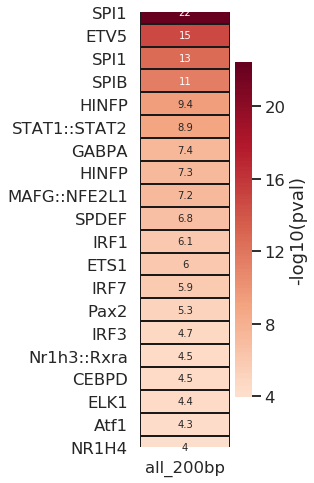

In [21]:
fig, ax = plt.subplots(figsize=(2,8))

filtered_frame = filtered_frame.sort_values('all_200bp', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_200bp']].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_activatedEnhancers_mergedMotifs_allComparisons.png', bbox_inches='tight')

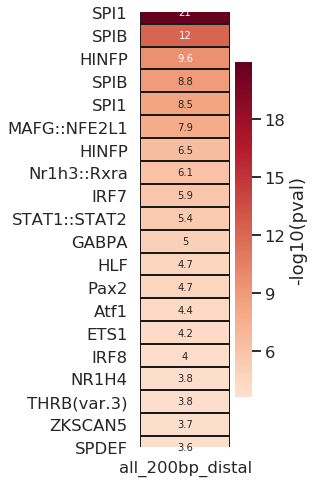

In [20]:
fig, ax = plt.subplots(figsize=(2,8))

filtered_frame = filtered_frame.sort_values('all_200bp_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_200bp_distal']].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_activatedDistalEnhancers_mergedMotifs_allComparisons.png', bbox_inches='tight')

In [14]:
rpkm = pd.read_csv('/gpfs/data01/glasslab/home/h1bennet/strains/data/RNA/HOMER.rawTPM.amln.txt', sep='\t')

# Look at TF Expression levels

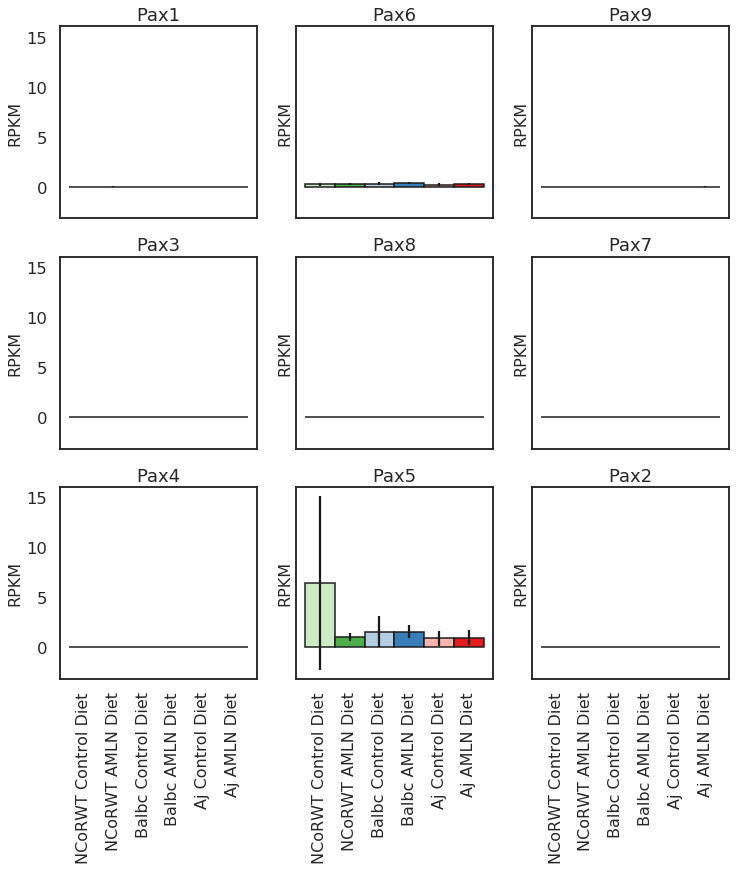

In [131]:
fig, axs = plt.subplots(3,3,figsize=(12,12), sharex=True, sharey=True)

count=0

for i in rpkm.loc[rpkm.index.str.contains('Pax[1-9]$'), :].index.tolist():
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

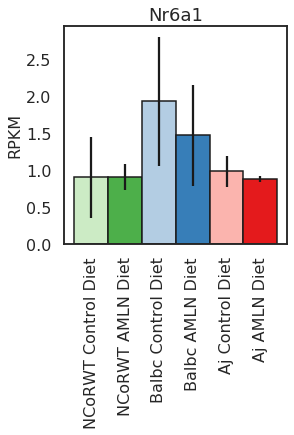

In [152]:
rpkm = survey_strain_amln_gene_exp('Nr6a1')

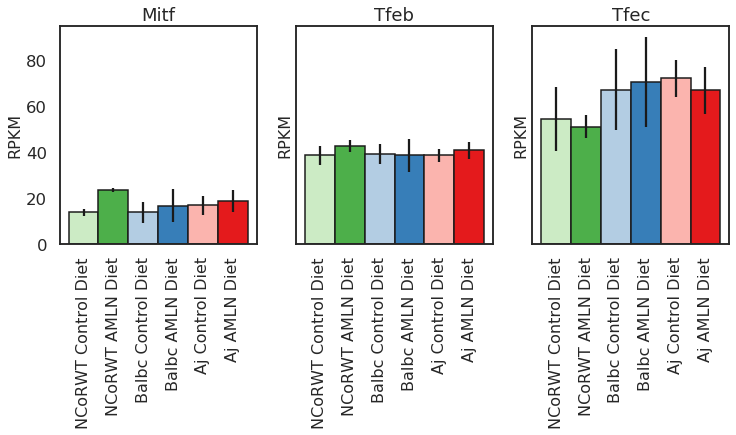

In [138]:
fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfeb', 'Tfec']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

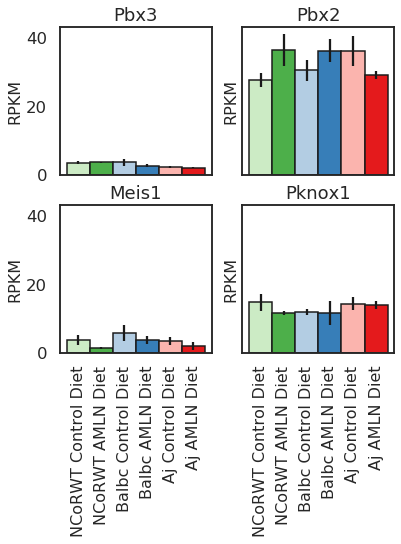

In [147]:
fig, axs = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)

count=0

for i in ['Pbx3', 'Pbx2', 'Meis1', 'Pknox1']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

In [149]:
rpkm.loc[rpkm.index.str.contains('Bach'), :]

,chr,start,end,strand,Length,Copies,Annotation/Divergence,aj_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_AJ12a_16_12_1,aj_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_AJ12b_16_12_1,balbc_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13a_JSSTDT_16_12_1,balbc_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13b_JSSTDT_16_12_1,balbc_Tim4PosKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13b_JSSTDT_16_12_1,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE1_CC1B_JSS_l20171006_GGTAG,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE2_CC1C_JSS_l20171006_ATGAG,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE3_CC1D_JSS_l20171006_ATTCC
gene,,,,,,,,,,,,,,,
Bach1,chr16,87698954,87733346,+,5851.0,1,Bach1|6230421P05Rik|AI323795|-|16|16 C3.3|prot...,42.284,47.377,38.528,52.811,30.577,40.853,39.973,40.023
Bach2os,chr4,32559680,32571662,-,1656.0,1,Bach2os|-|-|4|4 A5|ncRNA,39.409,36.493,44.942,33.432,28.295,55.059,41.474,48.139
Bach2,chr4,32417435,32586108,+,8486.0,1,Bach2|E030004N02Rik|-|4|4 A5|protein-coding,16.459,16.023,11.986,13.087,7.857,13.653,13.614,12.539


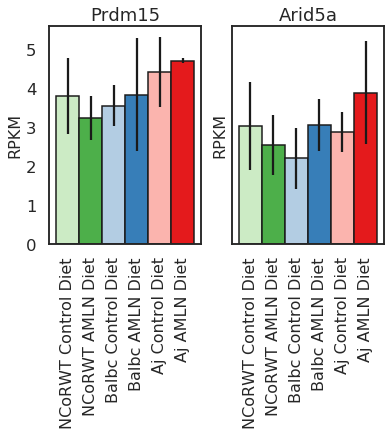

In [154]:
fig, axs = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)

count=0

for i in ['Prdm15', 'Arid5a']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1